In [3]:
# change current directory to parent folder
import os
import sys

if not os.path.isdir("pypsa-earth"):
    os.chdir("../../..")
sys.path.append(os.getcwd()+"/pypsa-earth/scripts")

from _helpers import three_2_two_digits_country

In [4]:
# OSM raw data files
substations_OSMraw_path = ("pypsa-earth/resources/osm/raw/all_raw_substations.geojson")
lines_OSMraw_path = ("pypsa-earth/resources/osm/raw/all_raw_lines.geojson")

# OSM cleaned data files
substations_OSMclean_path = ("pypsa-earth/resources/osm/clean/all_clean_substations.geojson")
lines_OSMclean_path = ("pypsa-earth/resources/osm/clean/all_clean_lines.geojson")

# shape files
countries_shape_path = "pypsa-earth/resources/shapes/country_shapes.geojson"

# solved networks output
base_path = "test4/pypsa-earth/saved_networks/Xenia_copy/elec_s_4_ec_lcopt_Co2L-1H.nc" 

In [5]:
# import packages

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product
import re

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\pypsa\networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


In [6]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
green1 = '#294839'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#927F48'
beige2 = '#A89677'
beige3 = '#D2CDAD'

from matplotlib.colors import ListedColormap




plt.rcParams['font.size'] = 18
zones = ['Northern', 'Oriental', 'Central', 'Southern']
zone_colors=[teal1,teal4,teal2,teal3]

# Define your custom colormap
cmap_zones = ListedColormap(zone_colors)

### Comparison capacity

In [7]:
# Custom powerplants ------------------------------------------------------------------
custom_pp = pd.read_csv("pypsa-earth/data/custom_powerplants.csv",delimiter=';')
#print(custom_pp)
custom_capacities = custom_pp.groupby(["Fueltype"]).sum()["Capacity"]
display(custom_capacities)
##display(custom_capacities.sum())
custom_con = custom_capacities.loc[['CCGT','OCGT','Oil']]
custom_index = ['Non-renewable']
conventional_capacity = pd.Series(custom_capacities.loc[['CCGT','OCGT','Oil']].sum(axis=0), index = custom_index)
#display(conventional_capacity)
#display(custom_con)

custom_capacities = pd.concat([custom_capacities,conventional_capacity])
custom_capacities = custom_capacities[['Bioenergy', 'Solar' , 'Wind', 'hydro', 'Non-renewable']]
new_index_names = {'Bioenergy': 'Biomass',  'hydro' : 'Hydro'}
custom_capacities = custom_capacities.rename(index=new_index_names).sort_index()
custom_capacities = pd.Series(custom_capacities)
display(custom_capacities)

Fueltype
Bioenergy      65.58
CCGT         1363.99
OCGT          948.92
Oil            11.74
Solar         164.90
Wind          127.34
hydro         732.20
Name: Capacity, dtype: float64

Biomass            65.58
Hydro             732.20
Non-renewable    2324.65
Solar             164.90
Wind              127.34
dtype: float64

In [33]:
# Data from CNDC ----------------------------------------------------------------------

# Path to the Excel file
excel_file = "C:/Users/marih/test4/pypsa-earth/data/electricity_2006-2021.xlsx"

# Read data from a specific worksheet by name
worksheet_name = 'Validation'
df = pd.read_excel(excel_file, sheet_name=worksheet_name)
df.set_index('carrier', inplace=True)
df.index = df.index.str.capitalize()
df_official = df["p_nom"]
new_index_names = {  'Gas' : 'Non-renewable', 'Onshore wind' : 'Wind'}
df_official = df_official.rename(index=new_index_names).sort_index()
display(df_official)

carrier
Biomass            66.00
Hydro             734.83
Non-renewable    2496.03
Solar             165.08
Wind              127.80
Name: p_nom, dtype: float64

In [46]:
# Data used by PyPSA -----------------------------------------------------------------------------------
powerplants_data = "C:/Users/marih/test4/pypsa-earth/resources/powerplants.csv"

available_generators = pd.read_csv(powerplants_data)
installed_capacity_resources = available_generators.groupby(["Country", "Fueltype"])["Capacity"].sum()
capacity_pypsa_fueltype = installed_capacity_resources.groupby(["Fueltype"]).sum()
pypsa_con = capacity_pypsa_fueltype.loc[['CCGT','OCGT','Oil']]
custom_index = ['Non-renewable']
capacity_pypsa_conventional = pd.Series(capacity_pypsa_fueltype.loc[['CCGT','OCGT','Oil']].sum(axis=0), index = custom_index)
capacity_pypsa_fueltype = pd.concat ([capacity_pypsa_fueltype,capacity_pypsa_conventional])
capacity_pypsa_fueltype = capacity_pypsa_fueltype[['Bioenergy', 'Solar' , 'Wind', 'hydro', 'Non-renewable']]
new_index_names = {'Bioenergy': 'Biomass', 'hydro':'Hydro'}
capacity_pypsa_fueltype = capacity_pypsa_fueltype.rename(index=new_index_names).sort_index()
display(capacity_pypsa_fueltype)
display(pypsa_con)



Biomass            65.58
Hydro             732.20
Non-renewable    2324.65
Solar             164.90
Wind              127.34
dtype: float64

Fueltype
CCGT    1363.99
OCGT     948.92
Oil       11.74
Name: Capacity, dtype: float64

In [66]:
# Old "Powerplants.csv" data ----------------------------------------------------------------------
solved_network = 'C:/Users/marih/test4/pypsa-earth/saved_networks/4_nodes_powerplants_old/elec_s_4_ec_lcopt_Co2L-1H.nc'
n = pypsa.Network(solved_network)
capacity_pypsa_fueltype_old = n.generators.groupby('carrier').p_nom.sum().drop('load').sort_index()
index = 'Hydro'
hydro_p_nom = n.storage_units.p_nom.sum()
Hydro =  pd.Series(data=hydro_p_nom, index=[index])
#display(capacity_pypsa_fueltype_old)

custom_index = ['Non-renewable']

capacity_pypsa_conventional_old = pd.Series(capacity_pypsa_fueltype_old.loc[['OCGT','oil']].sum(axis=0), index = custom_index)
capacity_pypsa_fueltype_old = pd.concat([capacity_pypsa_fueltype_old,capacity_pypsa_conventional_old])
capacity_pypsa_fueltype_old['ror']=capacity_pypsa_fueltype_old['ror'] + Hydro.values
new_indices = {'onwind': 'Wind', 'ror': 'Hydro', 'solar': 'Solar', 'biomass' : 'Biomass', 'oil' : 'Oil'}
capacity_pypsa_fueltype_old = capacity_pypsa_fueltype_old.rename(new_indices).sort_index()
pypsa_con_old = capacity_pypsa_fueltype_old.loc[['OCGT','Oil']]
capacity_pypsa_fueltype_old = capacity_pypsa_fueltype_old.drop(['OCGT','Oil', 'CCGT'])

display(capacity_pypsa_fueltype_old)
#Hydro

c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, pleas

Biomass           55.58
Hydro            732.20
Non-renewable    960.66
Solar            114.90
Wind              26.54
dtype: float64

In [62]:
# New capacity -----------------------------------------------------------------------------------
""" 
year = 2035
solved_network = f'C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working/pypsa-earth/Scenario_A_baseline_results/Baseline_{year}.nc'
n_solve = pypsa.Network(solved_network)
n = n_solve
cap_new = pd.DataFrame(n.generators.p_nom_opt)
cap_new['Carrier'] = cap_new.index.str.split().str[2]

#Group the capacities by the number
grouped = cap_new.groupby('Carrier').sum()
grouped = grouped.drop('load')
custom_index = ['Non-renewable']
new_con = pd.Series(grouped.loc[['OCGT','oil','OCGT']].sum(axis=0), index = custom_index)
display(new_con)

new_indices = {'onwind': 'Wind', 'solar': 'Solar','biomas':'Biomass'} """

" \nyear = 2035\nsolved_network = f'C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working/pypsa-earth/Scenario_A_baseline_results/Baseline_{year}.nc'\nn_solve = pypsa.Network(solved_network)\nn = n_solve\ncap_new = pd.DataFrame(n.generators.p_nom_opt)\ncap_new['Carrier'] = cap_new.index.str.split().str[2]\n\n#Group the capacities by the number\ngrouped = cap_new.groupby('Carrier').sum()\ngrouped = grouped.drop('load')\ncustom_index = ['Non-renewable']\nnew_con = pd.Series(grouped.loc[['OCGT','oil','OCGT']].sum(axis=0), index = custom_index)\ndisplay(new_con)\n\nnew_indices = {'onwind': 'Wind', 'solar': 'Solar','biomas':'Biomass'} "

1889.88

3414.67

3589.7400000000002

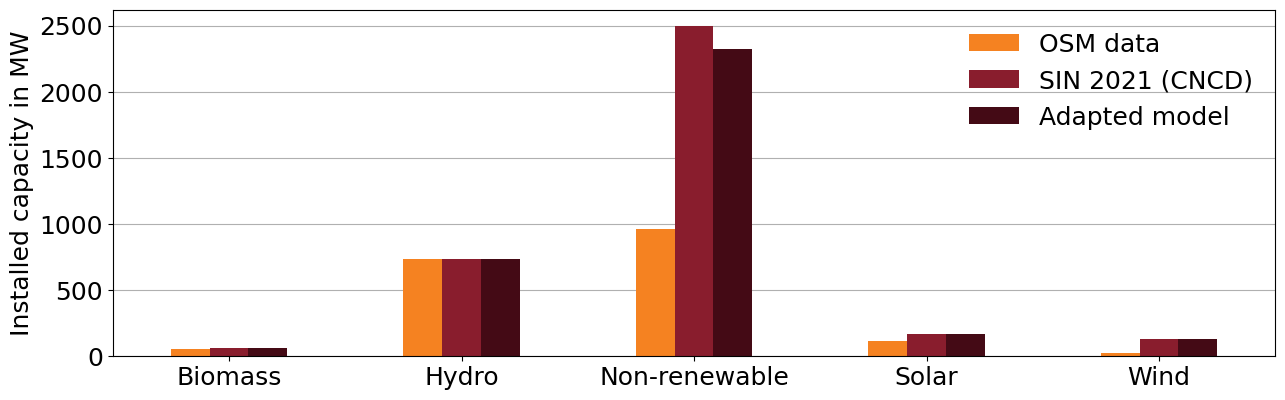

In [63]:
# Create one DataFrame with everything
all = pd.concat([ capacity_pypsa_fueltype_old.rename("OSM data"),df_official.rename("SIN 2021 (CNCD)"),custom_capacities.rename("Adapted model") ], axis=1) #

all.plot.bar( color = [orange,red1, brown],figsize=(15,4.5),zorder=2) #,brown
#df_official.plot.bar(label="Ministry 2021", color = purple1)
plt.ylabel('Installed capacity in MW')
plt.xticks(rotation=0)
plt.legend(frameon=False)
plt.grid(axis='y',zorder=0)

display(capacity_pypsa_fueltype_old.sum())
display(custom_capacities.sum())
display(df_official.sum())

Fueltype
OCGT    False
dtype: bool

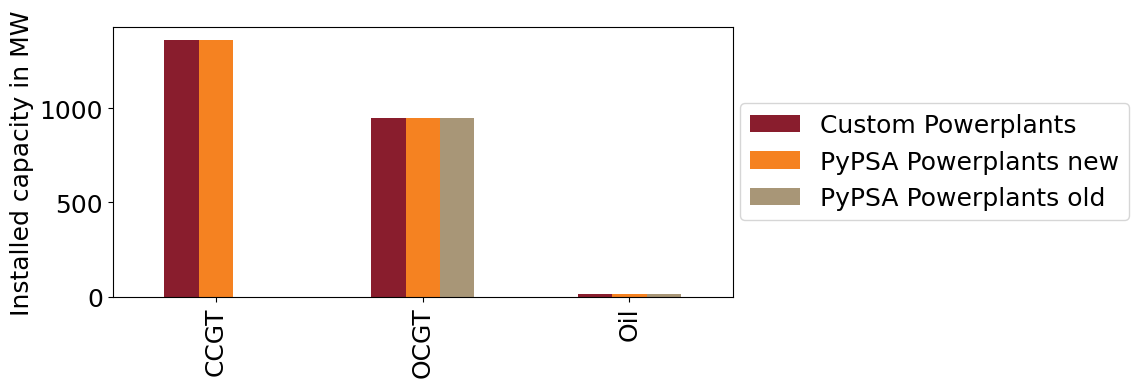

In [64]:
# Conventional capacities

con_all = pd.concat([ custom_con.rename('Custom Powerplants'), pypsa_con.rename('PyPSA Powerplants new'),pypsa_con_old.rename('PyPSA Powerplants old')], axis = 1)

con_all.plot.bar(color=[red1, orange,beige2],figsize=(8,3.5))
plt.legend(loc='center right', bbox_to_anchor=(1.66, 0.5))
plt.ylabel('Installed capacity in MW')

custom_con.loc[['OCGT']] + pypsa_con_old.loc[['OCGT']] == pypsa_con.loc[['OCGT']]